# Micromagnetic standard problem 4

**Author**: Marijan Beg, Marc-Antonio Bisotti

**Date**: 18 Mar 2016

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem specification

The simulated sample is a thin film cuboid with dimensions:
- length $L = 500 \,\text{nm}$,
- width $d = 125 \,\text{nm}$, and
- thickness $t = 3 \,\text{nm}$.

In [2]:
from fidimag.common import CuboidMesh
mesh = CuboidMesh(nx=160, ny=40, nz=1, dx=3.125, dy=3.125, dz=3, unit_length=1e-9)

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = -\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff}) + \alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ is the gyromagnetic ratio and $\alpha=0.02$ is the Gilbert damping.

In [3]:
A = 13e-12
Ms = 8.0e5
alpha = 0.02
gamma = 2.211e5

In the standard problem 4, the system is firstly relaxed at zero external magnetic field and then, stating from the obtained equlibrium configuration, the magnetisation dynamics is simulated for each of two different external magnetic fields:

1. $\mathbf{H}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$
2. $\mathbf{H}_{2} = (-35.5, -6.3, 0.0) \,\text{mT}$

The micromagnetic standard problem 4 specification can be also found in Ref. 1.

## Simulation

### Getting the Initial Magnetisation

The simulation object is created and parameters set.

In [4]:
from fidimag.micro import Sim, UniformExchange, Demag, Zeeman, TimeZeeman

sim = Sim(mesh)  # create simulation object

sim.driver.set_tols(rtol=1e-10, atol=1e-10)
sim.Ms = Ms
sim.driver.alpha = 0.5  # large value since the magnetisation dynamics is not important in the relexation stage
sim.driver.gamma = gamma
sim.driver.do_precession = False  # speeds up the simulation


# Starting magnetisation.
sim.set_m((1, 0.25, 0.1))
sim.add(UniformExchange(A=A))
sim.add(Demag())

We have ignored the decaying external field. Finally, the system can be relaxed and the obtained equilibrium configuration saved, so that it can be used as an initial state for simulating magnetisation dynamics.

In [5]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
sim.driver.relax(dt=1e-13, stopping_dmdt=0.01, max_steps=5000, save_m_steps=None, save_vtk_steps=None);
np.save("m0.npy", sim.spin)  # save equilibrium configuration

step=1, time=1e-13, max_dmdt=517 ode_step=0
step=2, time=2e-13, max_dmdt=510 ode_step=1.8e-14
step=3, time=3e-13, max_dmdt=502 ode_step=4.38e-14
step=4, time=4e-13, max_dmdt=495 ode_step=4.38e-14
step=5, time=5e-13, max_dmdt=489 ode_step=7.03e-14
step=6, time=6e-13, max_dmdt=482 ode_step=7.03e-14
step=7, time=7e-13, max_dmdt=476 ode_step=7.03e-14
step=8, time=8e-13, max_dmdt=470 ode_step=7.03e-14
step=9, time=9e-13, max_dmdt=464 ode_step=7.03e-14
step=10, time=1e-12, max_dmdt=459 ode_step=7.03e-14
step=11, time=1.14e-12, max_dmdt=453 ode_step=1.43e-13
step=12, time=1.29e-12, max_dmdt=445 ode_step=1.43e-13
step=13, time=1.43e-12, max_dmdt=439 ode_step=1.43e-13
step=14, time=1.57e-12, max_dmdt=433 ode_step=1.43e-13
step=15, time=1.72e-12, max_dmdt=428 ode_step=1.43e-13
step=16, time=1.86e-12, max_dmdt=422 ode_step=1.43e-13
step=17, time=2e-12, max_dmdt=417 ode_step=1.43e-13
step=18, time=2.15e-12, max_dmdt=412 ode_step=1.43e-13
step=19, time=2.29e-12, max_dmdt=407 ode_step=1.43e-13
step=

We not plot the magnetisation configuration,

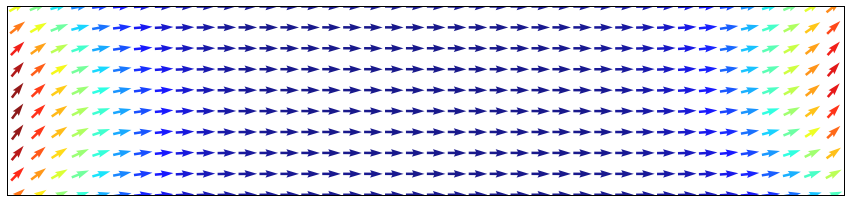

[  9.66821767e-01   1.25543432e-01   3.11232500e-18]


In [6]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
m = sim.spin
m.shape = (-1,3)
mx = m[:,0]
my = m[:,1]
mx.shape = (40, 160)
my.shape = (40, 160)
fig = plt.figure(figsize=(15,5))
plt.axes().set_aspect('equal')
plt.quiver(mx[1::4,1::4], my[::4,::4], my[::4,::4], pivot='mid', alpha=0.9, scale=45, cmap=plt.get_cmap('jet'), edgecolors='None' )
plt.xlim([-0.5,39.5])
plt.xticks([])
plt.yticks([])
plt.show()
print(np.average(m[:,:], axis=0))

With the obtained relaxed magnetisation, the magnetisation evolution can be simulated for the two different external magnetic fields using the following function:

In [7]:
def field_simulation(H, name):
    print(name)
    sim = Sim(mesh, name)
    sim.driver.alpha = alpha
    sim.driver.gamma = gamma
    sim.Ms = Ms
    sim.add(UniformExchange(A=A))
    sim.add(Demag())
    sim.add(Zeeman(H))
    sim.set_m(np.load('m0.npy'))  # load the equilibrium magnetisation from the previous step
    
    timesteps = np.linspace(0, 0.2e-9, 21)
    for i, t in enumerate(timesteps):
        sim.driver.run_until(t)
        if i % 10 == 0:
            print("\tsimulated {} s".format(t))

Using the created field_simulation function, we obtain the average magnetisation components time evolutions. Note that we only run the simulation for a short time, a full version of this standard problem 4 can be found in folder examples/micromagnetic/std4.

In [8]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
mu0 = 4 * np.pi * 1e-7  # magnetic constant (H/m)
mT = 1e-3 / mu0  # millitesla

field_simulation([-24.6 * mT,  4.3 * mT, 0], "field_1")
#field_simulation([-35.5 * mT, -6.3 * mT, 0], "field_2")

field_1
	simulated 0.0 s
	simulated 1e-10 s
	simulated 2e-10 s


We could have saved the magnetisation dynamics in python objects on the fly. Instead, we chose to make use of fidimag's automatic saving capabilities and will now read our simulation results back in. 

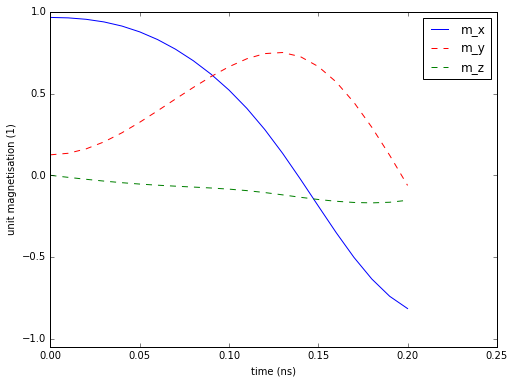

In [9]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
import matplotlib.pyplot as plt
%matplotlib inline
from fidimag.common.fileio import DataReader

def do_plot(data_name):
    dynamics = DataReader(data_name)
    # we could load the data with np.loadtxt, but using the DataReader gives 
    # us the possibility to use the column headers to access our data
    fig = plt.figure(figsize=(8, 6))
    axes = fig.add_subplot(111)
    axes.plot(dynamics["time"] * 1e9, dynamics["m_x"], "b-", label="m_x")
    axes.plot(dynamics["time"] * 1e9, dynamics["m_y"], "r--", label="m_y")
    axes.plot(dynamics["time"] * 1e9, dynamics["m_z"], "g--", label="m_z")
    axes.set_xlabel("time (ns)")                                             
    axes.set_xlim((0, 0.25))
    axes.set_ylabel("unit magnetisation (1)")                                
    axes.set_ylim((-1.05, 1))                                                
    axes.legend()
    plt.show()
    
do_plot('field_1.txt')

### References

[1] muMAG Micromagnetics Website. URL: http://www.ctcms.nist.gov/~rdm/mumag.org.html (Date of access: 26/02/2016)